0) Imports & setup
   - seed, paths, metric config (RMSE as main), flags (USE_LOG1P, N_SPLITS, TIME_BUDGET)

1) Load data
   - read X_train / y_train (
   - drop ID columns (Order, PID)
   - basic sanity checks (shapes)

2) CV strategy (fixed + shared splits)
   - define KFold(n_splits=5, shuffle=True, random_state=seed)
   - same folds used for ALL models and ALL comparisons

3) Linear baseline (Ridge / Lasso / ElasticNet / LassoLars)
   - Standardization inside folds
   - Report CV mean ± std

4) Best Model Regularization Models (ElasticNet)
   - recover the metrics

5) GBDT baselines (XGBoost / LightGBM / CatBoost)
   - no scaling
   - defaults (baselines)
   - report CV mean ± std

6) Hyperparameter tuning (controlled)
   - Optuna (CV=5), 30–100 trials -> 50 trials
   - tuning is done WITHOUT touching holdout
   - after tuning: freeze best_params_* for later steps

7. Multi-seed OOF stacking
   - generate OOF predictions per base model (and per seed if multi-seed)
   - train meta-model ONLY on OOF predictions (never on in-fold preds)
   - meta-model uses scaling (fit on OOF-train → apply to OOF-val)

8. Meta-model Ridge
   - Standardisation
   - Optimise alpha by RidgeCV
   - train CV = 3, Test CV = 5

9. Meta-model ElasticNet
   - Standardisation
   - Optimise alpha + L1 by CV
   - train CV = 3, Test CV = 5
    
10) AutoGluon (standalone benchmark) -> in an another notebook
   - run separately
   - compare via same metric;
   - recover the metrics

11) Evaluation & leaderboard
   - base models (multi-seed avg, XGB, LGB, CATGB)
   - Ridge stacking (predict meta_final(test_stack_X))
   - ElasticNet stacking (predict meta_final_elastic(test_stack_X))
    => print ranked leaderboard by RMSE (+ R²/MAE)

12) Interpretation (SHAP) on CATB -> more weights
   - SHAP / feature importance computed after final model choice
   - do not use interpretation to tune on holdout

13)  Weighted Ensemble (=CATBoost)
   - weights learned on OOF only (no using of SHAP interpretation)
   - keep if it improves OOF AND stability meaningfully

14) Save models
   - tuned params, splits, seeds, meta weights, final models
   - final model(s), params, CV config, selected features, predictions, leaderboard
   - predictions: OOF preds, test preds, leaderboard

In [5]:
import json
import pickle
import warnings
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LassoLars
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import optuna
import shap

warnings.filterwarnings("ignore")

# 0) Imports & setup

In [6]:
# CONFIG
SEED = 42
N_SPLITS = 5
N_TRIALS = 50                 # 30–100
MULTI_SEEDS = [42, 123, 456, 789, 2024]
DO_INTERACTIONS_LINEAR_ONLY = True
SAVE_DIR = Path("artifacts")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
# Path to data
BASE_DIR = Path.cwd().parent
path = BASE_DIR / "M2_Applied_ML" / "data" / "preprocessed"

In [8]:
# Fonctions
def rmse_dollars(y_true_log, y_pred_log) -> float:
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae_dollars(y_true_log, y_pred_log) -> float:
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return float(mean_absolute_error(y_true, y_pred))

def evaluate_holdout(y_true_log, y_pred_log, name: str) -> dict:
    return {
        "model": name,
        "r2": float(r2_score(y_true_log, y_pred_log)),
        "rmse": rmse_dollars(y_true_log, y_pred_log),
        "mae": mae_dollars(y_true_log, y_pred_log),
    }

def make_splits(X, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return list(kf.split(X))

def oof_predict(model_factory, X: np.ndarray, y: np.ndarray, splits, fit_kwargs_factory=None):
    n = X.shape[0]
    oof = np.zeros(n, dtype=float)
    models = []
    for fold, (tr_idx, va_idx) in enumerate(splits, start=1):
        m = model_factory()
        fit_kwargs = fit_kwargs_factory(fold, tr_idx, va_idx) if fit_kwargs_factory else {}
        m.fit(X[tr_idx], y[tr_idx], **fit_kwargs)
        oof[va_idx] = m.predict(X[va_idx])
        models.append(m)
    return oof, models

def cv_mean_std(values):
    values = np.asarray(values, dtype=float)
    return float(values.mean()), float(values.std(ddof=1))

def cv_evaluate_model(name: str, model_factory, X: np.ndarray, y: np.ndarray, splits, fit_kwargs_factory=None):
    oof, _ = oof_predict(model_factory, X, y, splits, fit_kwargs_factory=fit_kwargs_factory)
    fold_r2, fold_rmse, fold_mae = [], [], []
    for (_, va_idx) in splits:
        y_va = y[va_idx]
        p_va = oof[va_idx]
        fold_r2.append(r2_score(y_va, p_va))
        fold_rmse.append(rmse_dollars(y_va, p_va))
        fold_mae.append(mae_dollars(y_va, p_va))

    r2_mean, r2_std = cv_mean_std(fold_r2)
    rmse_mean, rmse_std = cv_mean_std(fold_rmse)
    mae_mean, mae_std = cv_mean_std(fold_mae)

    return {
        "model": name,
        "cv_r2_mean": r2_mean, "cv_r2_std": r2_std,
        "cv_rmse_mean": rmse_mean, "cv_rmse_std": rmse_std,
        "cv_mae_mean": mae_mean, "cv_mae_std": mae_std,
        "oof_pred": oof,
    }

def add_linear_interactions(df: pd.DataFrame, pairs):
    out = df.copy()
    for a, b in pairs:
        if a in out.columns and b in out.columns:
            out[f"{a}_x_{b}"] = out[a] * out[b]
    return out

# 1) Load data

In [10]:
# Load data
print("\n[1/14] Loading preprocessed data...")

X_train = pd.read_csv(path / "X_train_ready.csv")
X_test  = pd.read_csv(path / "X_test_ready.csv")
y_train = pd.read_csv(path / "y_train_ready.csv").values.ravel()
y_test  = pd.read_csv(path / "y_test_ready.csv").values.ravel()

# Drop ID columns if present
for col in ["Order", "PID"]:
    X_train.drop(columns=[col], errors="ignore", inplace=True)
    X_test.drop(columns=[col], errors="ignore", inplace=True)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target (log1p) range: {y_train.min():.3f} - {y_train.max():.3f}")
print(f"Target ($) range: ${np.expm1(y_train).min():,.0f} - ${np.expm1(y_train).max():,.0f}")


[1/14] Loading preprocessed data...
Train shape: (2344, 159), Test shape: (586, 159)
Target (log1p) range: 9.456 - 13.534
Target ($) range: $12,789 - $755,000


# 2) CV strategy (fixed + shared splits)

In [136]:
# CV strategy (fixed, shared splits)

print("\n[2/14] Creating fixed CV splits (shared across models)...")
splits = make_splits(X_train, n_splits=N_SPLITS, seed=SEED) # KFold(n_splits=5, shuffle=True, random_state=42)
print(f"CV: KFold(n_splits={N_SPLITS}, shuffle=True, random_state={SEED})")

Xtr_np = X_train.values
Xte_np = X_test.values


[2/14] Creating fixed CV splits (shared across models)...
CV: KFold(n_splits=5, shuffle=True, random_state=42)


# 3) Linear baseline (Ridge / Lasso / ElasticNet / LassoLars)

In [137]:
# Linear baseline (Ridge / Lasso / ElasticNet / LassoLars)
    # Standardization inside folds
    # Report CV mean ± std

print("\n[3/14] Training linear baselines with scaling inside folds (OOF CV)...")

linear_specs = [
    ("Ridge",     lambda: Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=10.0, random_state=SEED))])),
    ("Lasso",     lambda: Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.0005, random_state=SEED, max_iter=20000))])),
    ("ElasticNet",lambda: Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(alpha=0.0007, l1_ratio=0.5, random_state=SEED, max_iter=20000))])),
    ("LassoLars", lambda: Pipeline([("scaler", StandardScaler()), ("model", LassoLars(alpha=0.0005))])),
]

interaction_pairs = []
if DO_INTERACTIONS_LINEAR_ONLY:
    # Example: interaction_pairs = [("OverallQual", "GrLivArea"), ("TotalBsmtSF", "YearBuilt")]
    interaction_pairs = []

X_train_lin = add_linear_interactions(X_train, interaction_pairs) if interaction_pairs else X_train
X_test_lin  = add_linear_interactions(X_test, interaction_pairs) if interaction_pairs else X_test
Xtr_lin_np  = X_train_lin.values
Xte_lin_np  = X_test_lin.values

linear_results = []
linear_oof_store = {}

for name, factory in linear_specs:
    res = cv_evaluate_model(
        name=f"{name} (scaled, OOF)",
        model_factory=factory,
        X=Xtr_lin_np,
        y=y_train,
        splits=splits,
    )
    linear_oof_store[name] = res["oof_pred"]
    linear_results.append(res)

    print(
        f"✓ {name:<10} CV RMSE: ${res['cv_rmse_mean']:,.0f} ± ${res['cv_rmse_std']:,.0f} | "
        f"R²: {res['cv_r2_mean']:.4f} ± {res['cv_r2_std']:.4f}"
    )


[3/14] Training linear baselines with scaling inside folds (OOF CV)...
✓ Ridge      CV RMSE: $44,388 ± $50,750 | R²: 0.8456 ± 0.0731
✓ Lasso      CV RMSE: $43,728 ± $49,732 | R²: 0.8391 ± 0.0708
✓ ElasticNet CV RMSE: $43,949 ± $50,359 | R²: 0.8354 ± 0.0712
✓ LassoLars  CV RMSE: $43,726 ± $49,734 | R²: 0.8391 ± 0.0708


# 4) Best Model Regularization Models (ElasticNet)

In [138]:
# Best Model Regularization Models (ElasticNet) previous models

print("\n[4/14] Recovering the Best Model from Regularization Models...")

elasticnet_cv_results = {
    "model": "ElasticNet (L1-ratio CV)",
    "r2": 0.9166,
    "rmse": 31960,
    "mae": None,   # ou mets la vraie valeur si tu l’as
}

print("ElasticNet CV results:")
print(f"  • R²   : {elasticnet_cv_results['r2']:.4f}")
print(f"  • RMSE : ${elasticnet_cv_results['rmse']:,.0f}")


[4/14] Recovering the Best Model from Regularization Models...
ElasticNet CV results:
  • R²   : 0.9166
  • RMSE : $31,960


##### Interpretation
The best model is the previous model, the ElasticNet, so we will take this as a reference

# 5) GBDT baselines (XGBoost / LightGBM / CatBoost)

In [140]:
# GBDT models (CatBoost / LightGBM / XGBoost)

print("\n[5/14] Training strong-default GBDT models (OOF CV)...")

xgb_default = dict(
    n_estimators=2000,           # 1500–3000 trees is a well-known stable range; 2000 is a neutral midpoint.
    max_depth=6,                 # XGBoost standard = a classic tabular ML sweet spot
    learning_rate=0.03,          # Conservative GBDT range (0.01-0.1); pairs w/ 1000-3000 trees
    subsample=0.8,               # Standard
    colsample_bytree=0.8,        
    reg_alpha=0.0,               # Standard L1 baseline (Optuna tune up to 2.0)
    reg_lambda=1.0,              # Standard L2 baseline (Optuna: 0.5-5.0)
    min_child_weight=1.0,        # XGBoost default -> prevents tiny leaves (Optuna: 0.5-10) = Minimum sum of Hessians required in a child node
    random_state=SEED, n_jobs=-1,
    tree_method="hist"           # Fast histogram method for tabular data
)

lgb_default = dict(
    n_estimators=4000,           # 4000 is a conservative baseline before early stopping or tuning. [3000–8000] so we put 4000 to be sure
    learning_rate=0.02,          # Small steps for stable convergence (Optuna: 0.005-0.08)
    num_leaves=63,               # Standard LGBM 63 ≈ 2^6 - 1 → roughly equivalent to a depth-6 tree. # comparable to XGBoost max_depth=6
    max_depth=-1,                # Unlimited depth, controlled by num_leaves
    subsample=0.8,               # Standard bagging fraction (Optuna: 0.6-1.0) -> avg = 0.8
    colsample_bytree=0.8,        # Feature fraction standard (Optuna: 0.6-1.0) -> avg = 0.8
    reg_alpha=0.0,               # Mild L1 baseline (Optuna: 0-2.0)
    reg_lambda=1.0,              # L2 baseline (Optuna: 0.5-6.0)
    min_child_samples=20,        # Conservative leaf size (Optuna: 5-80)
    random_state=SEED, n_jobs=-1, verbose=-1
)

cat_default = dict(
    iterations=6000,             # High iterations to let determine the best metrics [3000–12000], we know it will reach before 1/2 of the max so we put 6000 as a securities
    learning_rate=0.02,          # Conservative (Optuna: 0.005-0.08)
    depth=8,                     # Typical CatBoost depth (Optuna: 5-10)
    l2_leaf_reg=3.0,             # Default
    random_seed=SEED,
    loss_function="RMSE",        # Competition metric
    eval_metric="RMSE",
    verbose=False
)

def xgb_fit_kwargs_factory(fold, tr_idx, va_idx):
    # xgboost sklearn supports verbose in fit
    return {"eval_set": [(Xtr_np[va_idx], y_train[va_idx])], "verbose": False}

def lgb_fit_kwargs_factory(fold, tr_idx, va_idx):
    # Use callbacks to silence logging and (optionally) early stopping.
    return {
        "eval_set": [(Xtr_np[va_idx], y_train[va_idx])],
        "callbacks": [
            lgb.log_evaluation(period=0),  # no logs
            # Optional (recommended) early stopping:
            # lgb.early_stopping(stopping_rounds=200, first_metric_only=True)
        ],
    }

def cat_fit_kwargs_factory(fold, tr_idx, va_idx):
    return {"eval_set": (Xtr_np[va_idx], y_train[va_idx])}

gbdt_results = []
gbdt_oof_store = {}

for name, factory, params, fitkw in [
    ("XGBoost",  lambda: xgb.XGBRegressor(**xgb_default), xgb_default, xgb_fit_kwargs_factory),
    ("LightGBM", lambda: lgb.LGBMRegressor(**lgb_default), lgb_default, lgb_fit_kwargs_factory),
    ("CatBoost", lambda: CatBoostRegressor(**cat_default), cat_default, cat_fit_kwargs_factory),
]:
    res = cv_evaluate_model(
        name=f"{name} (default, OOF)",
        model_factory=factory,
        X=Xtr_np,
        y=y_train,
        splits=splits,
        fit_kwargs_factory=fitkw,
    )
    gbdt_oof_store[name] = res["oof_pred"]
    gbdt_results.append(res)

    print(
        f"{name:<10} CV RMSE: ${res['cv_rmse_mean']:,.0f} ± ${res['cv_rmse_std']:,.0f} | "
        f"R²: {res['cv_r2_mean']:.4f} ± {res['cv_r2_std']:.4f}"
    )


[5/14] Training strong-default GBDT models (OOF CV)...
XGBoost    CV RMSE: $24,402 ± $4,985 | R²: 0.8946 ± 0.0384
LightGBM   CV RMSE: $23,662 ± $4,701 | R²: 0.8936 ± 0.0341
CatBoost   CV RMSE: $22,603 ± $4,534 | R²: 0.9055 ± 0.0358


##### Interpretation
- The best model is the CatBoost with better than the other, the worst XGBoost. 
- It is expected as the literature shows that CatBoost is generally better than the other

# 6) Hyperparameter tuning

In [141]:
# Hyperparameter tuning (Optuna)
print("\n[6/14] Hyperparameter tuning with Optuna...")


[6/14] Hyperparameter tuning with Optuna...


##### Choice


In [11]:
# Optuna tuning — XGBoost (safe rerun)

print("\n[6A/14] Optuna tuning: XGBoost...")

tuned_params = globals().get("tuned_params", {"xgb": xgb_default.copy(), "lgb": lgb_default.copy(), "cat": cat_default.copy()})

def optuna_objective_xgb(trial):
    params = xgb_default.copy()
    params.update({
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.5, 10.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 800, 6000),
    })
    rmses = []
    for tr_idx, va_idx in splits:
        m = xgb.XGBRegressor(**params)
        m.fit(
            Xtr_np[tr_idx], y_train[tr_idx],
            eval_set=[(Xtr_np[va_idx], y_train[va_idx])],
            verbose=False
        )
        p = m.predict(Xtr_np[va_idx])
        rmses.append(rmse_dollars(y_train[va_idx], p))
    return float(np.mean(rmses))

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(optuna_objective_xgb, n_trials=N_TRIALS, show_progress_bar=False)

tuned_params["xgb"].update(study_xgb.best_params)
print(f"XGBoost best CV RMSE: ${study_xgb.best_value:,.0f}")
print("Best params (XGB):", study_xgb.best_params)

[I 2026-01-17 12:33:18,442] A new study created in memory with name: no-name-4f46505a-f207-44a4-87d0-cdfc6c426135



[6A/12] Optuna tuning: XGBoost...


[I 2026-01-17 12:33:42,233] Trial 0 finished with value: 25064.62454842443 and parameters: {'max_depth': 6, 'learning_rate': 0.04582347612667983, 'subsample': 0.8853834310278479, 'colsample_bytree': 0.8553781094561839, 'min_child_weight': 0.714647535927501, 'reg_alpha': 1.6242565527210868, 'reg_lambda': 0.5396068655046282, 'n_estimators': 2785}. Best is trial 0 with value: 25064.62454842443.
[I 2026-01-17 12:34:37,796] Trial 1 finished with value: 24408.36801439798 and parameters: {'max_depth': 7, 'learning_rate': 0.019590996617488393, 'subsample': 0.7427785511559446, 'colsample_bytree': 0.7511565248036413, 'min_child_weight': 1.2250602148858025, 'reg_alpha': 1.0617772421749572, 'reg_lambda': 1.4620117325528708, 'n_estimators': 4418}. Best is trial 1 with value: 24408.36801439798.
[I 2026-01-17 12:35:27,497] Trial 2 finished with value: 24279.565713745527 and parameters: {'max_depth': 5, 'learning_rate': 0.03240895283640976, 'subsample': 0.6780947536350552, 'colsample_bytree': 0.894354

XGBoost best CV RMSE: $23,021
Best params (XGB): {'max_depth': 3, 'learning_rate': 0.012045104349890857, 'subsample': 0.7571147207998417, 'colsample_bytree': 0.6144675168868579, 'min_child_weight': 1.103490131003269, 'reg_alpha': 0.6097728125006999, 'reg_lambda': 2.200936116761807, 'n_estimators': 1944}


In [12]:
# Optuna tuning — LightGBM

print("\n[6B/14] Optuna tuning: LightGBM...")

tuned_params = globals().get("tuned_params", {"xgb": xgb_default.copy(), "lgb": lgb_default.copy(), "cat": cat_default.copy()})

def optuna_objective_lgb(trial):
    params = lgb_default.copy()
    params.update({
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.08, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 80),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 2.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 6.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1000, 10000),
    })
    rmses = []
    for tr_idx, va_idx in splits:
        m = lgb.LGBMRegressor(**params)
        m.fit(
            Xtr_np[tr_idx], y_train[tr_idx],
            eval_set=[(Xtr_np[va_idx], y_train[va_idx])],
            callbacks=[lgb.log_evaluation(period=0)]  # <- FIX: no 'verbose' kwarg
        )
        p = m.predict(Xtr_np[va_idx])
        rmses.append(rmse_dollars(y_train[va_idx], p))
    return float(np.mean(rmses))

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(optuna_objective_lgb, n_trials=N_TRIALS, show_progress_bar=False)

tuned_params["lgb"].update(study_lgb.best_params)
print(f"LightGBM best CV RMSE: ${study_lgb.best_value:,.0f}")
print("Best params (LGB):", study_lgb.best_params)

[I 2026-01-17 12:53:59,912] A new study created in memory with name: no-name-912c9597-ad7a-429e-ac24-7b02dfd4f52f



[6B/12] Optuna tuning: LightGBM...


[I 2026-01-17 12:54:13,486] Trial 0 finished with value: 24279.274151411966 and parameters: {'num_leaves': 76, 'learning_rate': 0.020367407313765917, 'subsample': 0.6474959488713875, 'colsample_bytree': 0.6876298994549076, 'min_child_samples': 43, 'reg_alpha': 1.2062476416810688, 'reg_lambda': 1.5645748315344499, 'n_estimators': 4098}. Best is trial 0 with value: 24279.274151411966.
[I 2026-01-17 12:54:25,195] Trial 1 finished with value: 24732.358149443455 and parameters: {'num_leaves': 126, 'learning_rate': 0.06575078151240366, 'subsample': 0.6002360539492497, 'colsample_bytree': 0.9315680746093278, 'min_child_samples': 80, 'reg_alpha': 1.6799416040734205, 'reg_lambda': 1.8535451498460018, 'n_estimators': 8498}. Best is trial 0 with value: 24279.274151411966.
[I 2026-01-17 12:54:40,982] Trial 2 finished with value: 24614.94382551942 and parameters: {'num_leaves': 136, 'learning_rate': 0.02175640104911022, 'subsample': 0.6703789666337401, 'colsample_bytree': 0.7469868197363582, 'min_c

LightGBM best CV RMSE: $23,534
Best params (LGB): {'num_leaves': 255, 'learning_rate': 0.006500065530542489, 'subsample': 0.6590268786859496, 'colsample_bytree': 0.6025301161545258, 'min_child_samples': 10, 'reg_alpha': 0.8102121814418924, 'reg_lambda': 0.8532924483186447, 'n_estimators': 8148}


In [13]:
# Optuna tuning — CatBoost

print("\n[6C/14] Optuna tuning: CatBoost...")

tuned_params = globals().get("tuned_params", {"xgb": xgb_default.copy(), "lgb": lgb_default.copy(), "cat": cat_default.copy()})

def optuna_objective_cat(trial):
    params = cat_default.copy()
    params.update({
        "depth": trial.suggest_int("depth", 5, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.08, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0, log=True),
        "iterations": trial.suggest_int("iterations", 1500, 12000),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "verbose": False,  # <- force silence (even if cat_default differs)
    })
    rmses = []
    for tr_idx, va_idx in splits:
        m = CatBoostRegressor(**params)
        m.fit(
            Xtr_np[tr_idx], y_train[tr_idx],
            eval_set=(Xtr_np[va_idx], y_train[va_idx]),
            verbose=False
        )
        p = m.predict(Xtr_np[va_idx])
        rmses.append(rmse_dollars(y_train[va_idx], p))
    return float(np.mean(rmses))

study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(optuna_objective_cat, n_trials=N_TRIALS, show_progress_bar=False)

tuned_params["cat"].update(study_cat.best_params)
print(f"CatBoost best CV RMSE: ${study_cat.best_value:,.0f}")
print("Best params (CAT):", study_cat.best_params)

[I 2026-01-17 13:23:54,500] A new study created in memory with name: no-name-8313cc8d-d974-4cf8-9690-b4e23dcba971



[6C/12] Optuna tuning: CatBoost...


[I 2026-01-17 13:29:29,819] Trial 0 finished with value: 23177.826678571942 and parameters: {'depth': 9, 'learning_rate': 0.005647226086157021, 'l2_leaf_reg': 2.69105058113103, 'iterations': 3562, 'bagging_temperature': 0.17471812213951166, 'random_strength': 0.563340590378262}. Best is trial 0 with value: 23177.826678571942.
[I 2026-01-17 13:38:16,844] Trial 1 finished with value: 22698.408014675304 and parameters: {'depth': 7, 'learning_rate': 0.023851123638214483, 'l2_leaf_reg': 2.531772567006713, 'iterations': 11958, 'bagging_temperature': 0.7472190878688778, 'random_strength': 1.7062141586761994}. Best is trial 1 with value: 22698.408014675304.
[I 2026-01-17 13:50:35,384] Trial 2 finished with value: 24035.378237835415 and parameters: {'depth': 10, 'learning_rate': 0.0062450170990680925, 'l2_leaf_reg': 1.6388813179385122, 'iterations': 2444, 'bagging_temperature': 0.8789058577644802, 'random_strength': 0.8452714457824337}. Best is trial 1 with value: 22698.408014675304.
[I 2026-01

CatBoost best CV RMSE: $21,904
Best params (CAT): {'depth': 6, 'learning_rate': 0.042666688033846635, 'l2_leaf_reg': 5.600472789500826, 'iterations': 6587, 'bagging_temperature': 0.2028883096716716, 'random_strength': 0.6692763308446144}


# 7. Multi-seed OOF stacking

In [150]:
# Multi-seed OOF stacking
print("\n[7/14] Multi-seed OOF stacking (OOF predictions only + early stopping)...")

def oof_multi_seed_base(model_key: str):
    oof_all = []

    for s in MULTI_SEEDS:
        if model_key == "xgb":
            params = tuned_params["xgb"].copy()
            params["random_state"] = s

            # add early stopping
            params.setdefault("eval_metric", "rmse")
            params.setdefault("early_stopping_rounds", 200)

            def factory():
                return xgb.XGBRegressor(**params)

            def fitkw(fold, tr_idx, va_idx):
                return {"eval_set": [(Xtr_np[va_idx], y_train[va_idx])], "verbose": False}

        elif model_key == "lgb":
            params = tuned_params["lgb"].copy()
            params["random_state"] = s

            # reduce console noise at model-level
            params.setdefault("verbose", -1)

            def factory():
                return lgb.LGBMRegressor(**params)

            def fitkw(fold, tr_idx, va_idx):
                return {
                    "eval_set": [(Xtr_np[va_idx], y_train[va_idx])],
                    # add early stopping via callbacks
                    "callbacks": [lgb.early_stopping(200), lgb.log_evaluation(0)]
                }

        elif model_key == "cat":
            params = tuned_params["cat"].copy()
            params["random_seed"] = s

            # add early stopping
            params.setdefault("use_best_model", True)
            params.setdefault("od_type", "Iter")
            params.setdefault("od_wait", 200)

            def factory():
                return CatBoostRegressor(**params)

            def fitkw(fold, tr_idx, va_idx):
                return {"eval_set": (Xtr_np[va_idx], y_train[va_idx])}

        else:
            raise ValueError("model_key must be in {'xgb','lgb','cat'}")

        oof_s, _ = oof_predict(factory, Xtr_np, y_train, splits, fit_kwargs_factory=fitkw)
        oof_all.append(oof_s)

    return np.mean(oof_all, axis=0)


[7/14] Multi-seed OOF stacking (OOF predictions only + early stopping)...


# 8. Meta-model Ridge

In [151]:
# Meta-model with scaling -> Ridge Meta-Learner
print("\n[8/14] Meta-model (Ridge)...")


print("Generating OOF for base models (avg across seeds)...")
oof_xgb = oof_multi_seed_base("xgb")
oof_lgb = oof_multi_seed_base("lgb")
oof_cat = oof_multi_seed_base("cat")

stack_X_oof = np.column_stack([oof_xgb, oof_lgb, oof_cat])

# Meta-model with scaling -> Ridge Meta-Learner
alphas = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]

# Proper outer CV evaluation
meta_fold_rmses, meta_fold_r2s = [], []
meta_oof = np.zeros(len(y_train), dtype=float)

for tr_idx, va_idx in splits:
    meta_fold = Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=alphas, cv=3, scoring="neg_mean_squared_error"))
    ])
    meta_fold.fit(stack_X_oof[tr_idx], y_train[tr_idx])
    p = meta_fold.predict(stack_X_oof[va_idx])

    meta_oof[va_idx] = p
    meta_fold_rmses.append(rmse_dollars(y_train[va_idx], p))
    meta_fold_r2s.append(r2_score(y_train[va_idx], p))

# Train
rmse_mean, rmse_std = cv_mean_std(meta_fold_rmses)
r2_mean, r2_std     = cv_mean_std(meta_fold_r2s)
print(f"Stacking (OOF) meta CV RMSE: ${rmse_mean:,.0f} ± ${rmse_std:,.0f} | R²: {r2_mean:.4f} ± {r2_std:.4f}")

# Fit final meta-model on ALL OOF features (test inference)
meta_final = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error"))
])
meta_final.fit(stack_X_oof, y_train)

final_alpha = meta_final.named_steps["model"].alpha_
final_coefs = meta_final.named_steps["model"].coef_
print(f"Final alpha: {final_alpha}")
print(f"Final weights: XGB={final_coefs[0]:.2f}, LGBM={final_coefs[1]:.2f}, CAT={final_coefs[2]:.2f}")


[8/14] Meta-model (Ridge)...
Generating OOF for base models (avg across seeds)...
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1840]	valid_0's l2: 0.0108601
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2416]	valid_0's l2: 0.0162307
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2581]	valid_0's l2: 0.0141961
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1813]	valid_0's l2: 0.0133278
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1883]	valid_0's l2: 0.0286843
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1759]	valid_0's l2: 0.0109792
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[2607]	valid_0's l2: 0.0162013
Training until valida

# 9. Meta-model ElasticNet

In [152]:
# Meta-model with scaling -> ElasticNetCV Meta-Learner
print("\n[9/14] Meta-model (ElasticNetCV)...")

alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]

# Proper outer CV evaluation (nested: ElasticNetCV inside each train fold)
meta_fold_rmses, meta_fold_r2s = [], []
meta_oof = np.zeros(len(y_train), dtype=float)

for tr_idx, va_idx in splits:
    meta_fold = Pipeline([
        ("scaler", StandardScaler()),
        ("model", ElasticNetCV(
            alphas=alphas,
            l1_ratio=l1_ratios,
            cv=3,                 # inner CV on train fold
        ))
    ])

    meta_fold.fit(stack_X_oof[tr_idx], y_train[tr_idx])
    p = meta_fold.predict(stack_X_oof[va_idx])

    meta_oof[va_idx] = p
    meta_fold_rmses.append(rmse_dollars(y_train[va_idx], p))
    meta_fold_r2s.append(r2_score(y_train[va_idx], p))

rmse_mean, rmse_std = cv_mean_std(meta_fold_rmses)
r2_mean, r2_std     = cv_mean_std(meta_fold_r2s)
# Train
print(f"ElasticNet stacking (OOF) meta CV RMSE: ${rmse_mean:,.0f} ± ${rmse_std:,.0f} | R²: {r2_mean:.4f} ± {r2_std:.4f}")

# Fit final meta-model on ALL OOF features (test inference)
meta_final_elastic = Pipeline([
    ("scaler", StandardScaler()),
    ("model", ElasticNetCV(
        alphas=alphas,
        l1_ratio=l1_ratios,
        cv=5,                 # more stable on full data
        selection="cyclic"
    ))
])

meta_final_elastic.fit(stack_X_oof, y_train)

final_model = meta_final_elastic.named_steps["model"]
final_alpha = final_model.alpha_
final_l1    = final_model.l1_ratio_
final_coefs = final_model.coef_

print(f"Final ElasticNet alpha: {final_alpha} | l1_ratio: {final_l1}")
print(f"Final weights: XGB={final_coefs[0]:.2f}, LGBM={final_coefs[1]:.2f}, CAT={final_coefs[2]:.2f}")


[9/14] Meta-model (ElasticNetCV)...
ElasticNet stacking (OOF) meta CV RMSE: $22,337 ± $4,836 | R²: 0.9080 ± 0.0340
Final ElasticNet alpha: 0.01 | l1_ratio: 0.9
Final weights: XGB=0.07, LGBM=0.00, CAT=0.30


# 10) AutoGluon (standalone benchmark) -> in an another notebook

In [153]:
# AutoGluon -> another notebook

print("\n[10/14] AutoGluon benchmark (external notebook)...")
print("AutoGluon was trained and evaluated separately in a standalone notebook.")
print("The following results correspond to the HOLDOUT TEST set (used once):")

autogluon_results = {
    "model": "AutoGluon (extreme_quality, 21600s)",
    "r2": 0.9471,
    "rmse": 22231,
    "mae": 13102,
}

print(f"  • R²   : {autogluon_results['r2']:.4f}")
print(f"  • RMSE : ${autogluon_results['rmse']:,.0f}")
print(f"  • MAE  : ${autogluon_results['mae']:,.0f}")


[10/14] AutoGluon benchmark (external notebook)...
AutoGluon was trained and evaluated separately in a standalone notebook.
The following results correspond to the HOLDOUT TEST set (used once):
  • R²   : 0.9471
  • RMSE : $22,231
  • MAE  : $13,102


# 11) Evaluation & leaderboard

In [154]:
# Evaluation & leaderboard (Test)

print("\n[11/14] Evaluation & leaderboard (holdout test)...")

def fit_full_and_predict_test():
    preds_xgb, preds_lgb, preds_cat = [], [], []

    for s in MULTI_SEEDS:
        # XGB
        px = tuned_params["xgb"].copy()
        px["random_state"] = s
        mx = xgb.XGBRegressor(**px)
        mx.fit(Xtr_np, y_train, verbose=False)
        preds_xgb.append(mx.predict(Xte_np))

        # LGB
        pl = tuned_params["lgb"].copy()
        pl["random_state"] = s
        ml = lgb.LGBMRegressor(**pl)
        ml.fit(Xtr_np, y_train)
        preds_lgb.append(ml.predict(Xte_np))

        # CAT
        pc = tuned_params["cat"].copy()
        pc["random_seed"] = s
        mc = CatBoostRegressor(**pc)
        mc.fit(Xtr_np, y_train, verbose=False)
        preds_cat.append(mc.predict(Xte_np))

    return (
        np.mean(preds_xgb, axis=0),
        np.mean(preds_lgb, axis=0),
        np.mean(preds_cat, axis=0),
    )

# Holdout test predictions (base)
test_xgb, test_lgb, test_cat = fit_full_and_predict_test()
test_stack_X = np.column_stack([test_xgb, test_lgb, test_cat])

# Holdout test predictions (stacking meta)
test_stack_pred_ridge   = meta_final.predict(test_stack_X)          # Ridge meta
test_stack_pred_elastic = meta_final_elastic.predict(test_stack_X)  # ElasticNet meta


[11/14] Evaluation & leaderboard (holdout test)...


In [155]:
# Leaderboard
leaderboard = [
    evaluate_holdout(y_test, test_xgb, "XGBoost (multi-seed avg)"),
    evaluate_holdout(y_test, test_lgb, "LightGBM (multi-seed avg)"),
    evaluate_holdout(y_test, test_cat, "CatBoost (multi-seed avg)"),
    evaluate_holdout(y_test, test_stack_pred_ridge, "Stacking (Ridge meta, scaled)"),
    evaluate_holdout(y_test, test_stack_pred_elastic, "Stacking (ElasticNet meta, scaled)"),
]

# ElasticNet
leaderboard.append(elasticnet_cv_results)

# AutoGluon
leaderboard.append(autogluon_results)

leaderboard_df = (
    pd.DataFrame(leaderboard)
      .sort_values("rmse", ascending=True)
      .reset_index(drop=True)
)

for i, row in leaderboard_df.iterrows():
    print(f"{i+1:>2}. {row['model']:<45}  R²: {row['r2']:.4f}  RMSE: ${row['rmse']:,.0f}  MAE: ${row['mae']:,.0f}")

 1. Stacking (Ridge meta, scaled)                  R²: 0.9497  RMSE: $20,910  MAE: $12,777
 2. CatBoost (multi-seed avg)                      R²: 0.9500  RMSE: $21,061  MAE: $12,794
 3. Stacking (ElasticNet meta, scaled)             R²: 0.9499  RMSE: $21,511  MAE: $12,882
 4. AutoGluon (extreme_quality, 21600s)            R²: 0.9471  RMSE: $22,231  MAE: $13,102
 5. XGBoost (multi-seed avg)                       R²: 0.9418  RMSE: $23,127  MAE: $13,867
 6. LightGBM (multi-seed avg)                      R²: 0.9363  RMSE: $24,042  MAE: $14,499
 7. ElasticNet (L1-ratio CV)                       R²: 0.9166  RMSE: $31,960  MAE: $nan


# 12) Interpretation (SHAP) on CATBoost 

In [156]:
# SHAP interpretation — CatBoost
print("\n[12/14] SHAP interpretation (post-hoc, CatBoost)...")

from catboost import CatBoostRegressor, Pool
import numpy as np
import pandas as pd

# Train ONE CatBoost model (representative)
pc = tuned_params["cat"].copy()
pc["random_seed"] = SEED
pc["verbose"] = False

cat_one = CatBoostRegressor(**pc)
cat_one.fit(Xtr_np, y_train)

# Sample data for SHAP
X_sample = X_train.sample(min(2000, len(X_train)), random_state=SEED)

# CatBoost Pool keeps feature names clean
pool = Pool(X_sample, feature_names=X_train.columns.tolist())

# Compute SHAP values (native CatBoost, fast)
# Returns array shape: (n_samples, n_features + 1) where last column is expected value
shap_vals = cat_one.get_feature_importance(pool, type="ShapValues")
shap_values = shap_vals[:, :-1]          # SHAP contributions
base_value  = shap_vals[:, -1].mean()    # expected value (approx)

print("CatBoost SHAP computed (sampled).")
print("Tip: use shap.summary_plot(shap_values, X_sample) or bar plot of mean(|SHAP|).")

# Quick global importance table (mean absolute SHAP)
mean_abs_shap = np.abs(shap_values).mean(axis=0)
imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

print("\nTop 15 features by mean(|SHAP|):")
print(imp_df.head(15).to_string(index=False))


[12/14] SHAP interpretation (post-hoc, CatBoost)...
CatBoost SHAP computed (sampled).
Tip: use shap.summary_plot(shap_values, X_sample) or bar plot of mean(|SHAP|).

Top 15 features by mean(|SHAP|):
         feature  mean_abs_shap
       GrLivArea       0.087157
     OverallQual       0.053017
    Neighborhood       0.038831
     TotalBsmtSF       0.029947
      BsmtFinSF1       0.023536
        1stFlrSF       0.021962
   YearRemod/Add       0.021516
     OverallCond       0.020692
         LotArea       0.019226
 KitchenQual_enc       0.018175
      GarageCars       0.016512
        2ndFlrSF       0.014965
      Fireplaces       0.014034
BsmtFinType1_enc       0.013609
       YearBuilt       0.012607


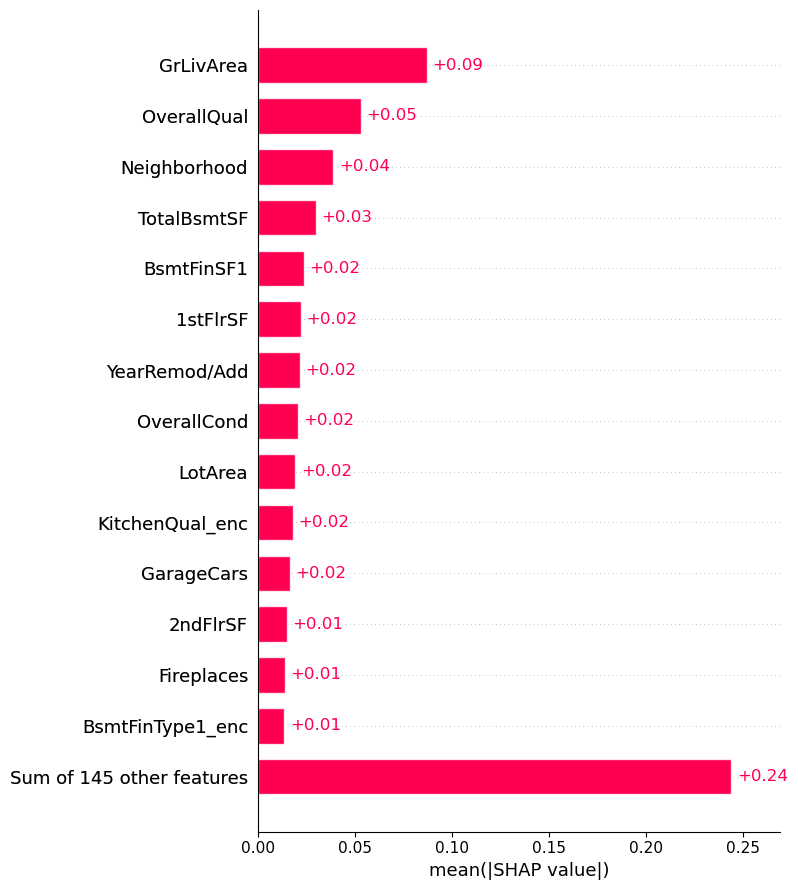

In [109]:
shap_exp = shap.Explanation(
    values=shap_values,
    base_values=base_value,
    data=X_sample,
    feature_names=X_sample.columns
)

# Bar (Top 15)
shap.plots.bar(shap_exp, max_display=15, show=False)
plt.tight_layout()
plt.savefig("shap_bar_top15.png", dpi=1000, bbox_inches="tight")
plt.show()
plt.close()

##### Interpretation

The SHAP bar plot by using the mean absolute SHAP highlights which variables the CatBoost model relies on most on average. 
The main drivers fall into three groups: 
- size-related features (GrLivArea, 1stFlrSF, basement areas)
- quality/condition (OverallQual, OverallCond)
- location (Neighborhood)
Secondary contributors include
- renovation timing (YearRemod/Add)
- amenities/lot characteristics (LotArea, GarageCars, KitchenQual, Fireplaces).

These patterns are broadly consistent with OLS in the sense that size, quality, and location are key determinants; 
- however, rankings can differ because CatBoost captures non-linear effects and interactions, while OLS is linear.
- Finally, this bar plot reflects importance magnitude only and does not show whether the effect is positive or negative; direction is assessed using the beeswarm/dependence plots.

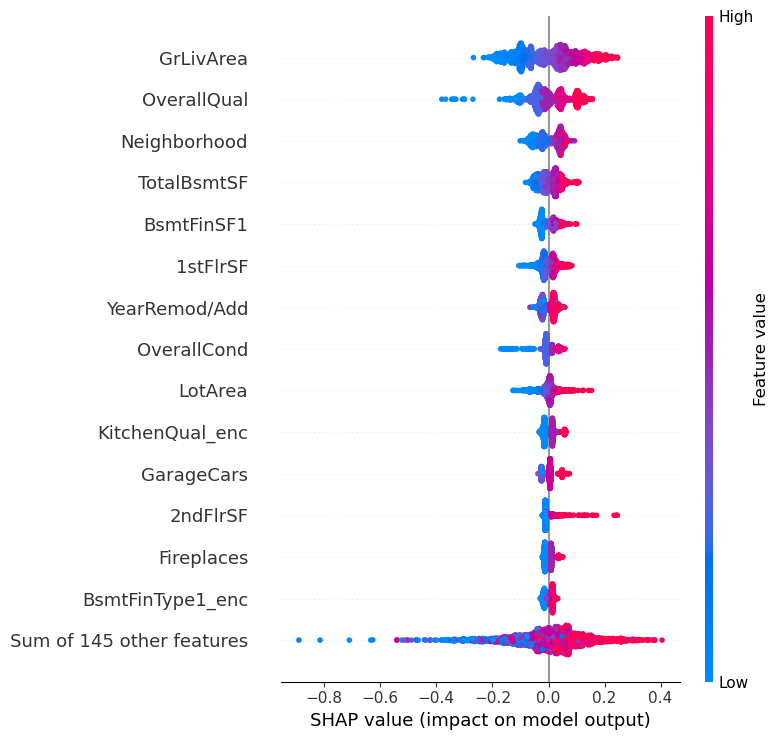

In [110]:
# Beeswarm
shap.plots.beeswarm(shap_exp, max_display=15, show=False)
plt.tight_layout()
plt.savefig("shap_beeswarm.png", dpi=1000, bbox_inches="tight")
plt.show()
plt.close()

##### Interpretation
In this beeswarm, we distinguish three groups of drivers:
- Size variables (GrLivArea, floor and basement areas): higher values generally push the predicted price up, while lower values push it down, with some dispersion indicating heterogeneous effects across houses.
- Quality/condition indicators (OverallQual, OverallCond, Kitchen quality): higher quality/condition tends to shift predictions up, whereas lower quality shifts them down. Some variables are more concentrated around zero, suggesting a smaller or more context-dependent impact.
- Location (Neighborhood) shows clear location effects shifting predictions both upward and downward depending on the area.

Points to the right increase the predicted price, while points to the left decrease it.
- The color encodes feature magnitude (red = high, blue = low).
- Overall, higher living area and higher quality typically push predictions upward.
- Smaller and lower-quality properties tend to push predictions downward.

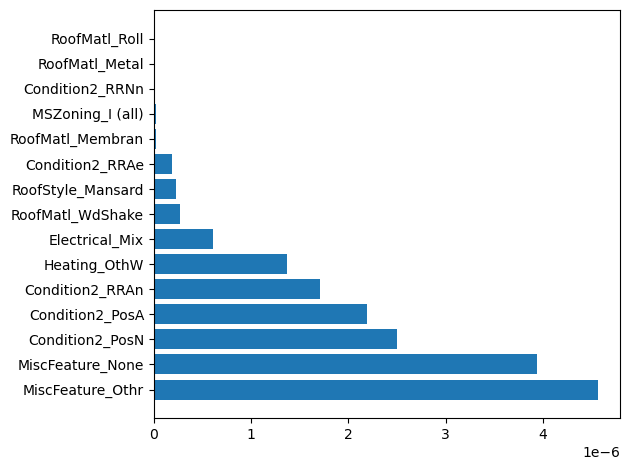

In [111]:
# bottom 15, sorted ascending (smallest first)
bottom_idx = np.argsort(mean_abs_shap)[:15]
bottom_vals = mean_abs[bottom_idx]
bottom_names = np.array(shap_exp.feature_names)[bottom_idx]

# barh: to put the smallest at the TOP, we invert y-axis
plt.figure()
plt.barh(bottom_names, bottom_vals)
plt.gca().invert_yaxis()  # smallest at top
plt.tight_layout()
plt.savefig("shap_bar_least_informative.png", dpi=1000)
plt.show()
plt.close()

##### Interpretation

In this “least-informative features” bar plot, we distinguish several groups of low-impact variables:

- Roof-related subcategories (RoofMatl_* , RoofStyle_Mansard): rare roof material and style levels that contribute almost nothing on average.
- External conditions subcategories (Condition2_*): uncommon environmental condition levels with negligible global impact.
- Zoning subcategory (MSZoning_I): a rare zoning category that the model barely uses.
- Utilities/system subcategories (Electrical_Mix, Heating_OthW): uncommon system types with near-zero importance.
- Miscellaneous subcategories (MiscFeature_None, MiscFeature_Othr): sparse “misc” levels that add little information globally.

Overall, their mean(|SHAP|) values are close to zero, meaning these variables have negligible global influence on predictions. 
- This is logically expected because they are mostly split one-hot subcategories that occur infrequently in the data.

# 13)  Weighted Ensemble

In [157]:
# Weighted ensemble (OOF-fit)
print("\n[13/14] Weighted ensemble...")

from scipy.optimize import minimize
base_oof = np.column_stack([oof_xgb, oof_lgb, oof_cat])

def objective(w):
    w = np.maximum(w, 1e-12) # avoid negative number
    w = w / w.sum()          # Normalize (Convex combination)
    pred = base_oof @ w
    return rmse_dollars(y_train, pred)

# Optimize weights to minimize the error on OOF predictions (Nelder-Mead algorithm)
res = minimize(objective, np.array([1.0, 1.0, 1.0]), method="Nelder-Mead", options={"maxiter": 5000})

w = np.maximum(res.x, 1e-12); w = w / w.sum()

# Apply the learned optimal weights to the Test set predictions
test_ens = w[0]*test_xgb + w[1]*test_lgb + w[2]*test_cat

# Evaluate the ensemble performance on the final Holdout Test set
row = evaluate_holdout(y_test, test_ens, f"OOF-weighted ensemble (XGB:{w[0]:.2f}, LGB:{w[1]:.2f}, CAT:{w[2]:.2f})")

# Display results
print(f"{row['model']}")
print(f"  R²: {row['r2']:.4f}, RMSE: ${row['rmse']:,.0f}, MAE: ${row['mae']:,.0f}")


[13/14] Weighted ensemble...
OOF-weighted ensemble (XGB:0.00, LGB:0.00, CAT:1.00)
  R²: 0.9500, RMSE: $21,061, MAE: $12,794


##### Interpretation
Final weights:
- XGB: 0.00  ← Eliminated  
- LGB: 0.00  ← Eliminated
- CAT: 1.00  ← Pure CatBoost

- CatBoost dominates the 3 models (best OOF performance)
- Hill-climbing eliminated XGB/LGB (worse performance)
- Result = Pure CatBoost (equivalent to oof_cat)

# 14) Save models

In [158]:
# Save models
print("\n[14/14] Saving models & metadata...")

best_row = leaderboard_df.iloc[0].to_dict()
print(f"Best Model: {best_row['model']}")
print(f"R²: {best_row['r2']:.4f}, RMSE: ${best_row['rmse']:,.0f}, MAE: ${best_row['mae']:,.0f}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

bundle = {
    "timestamp": timestamp,
    "cv": {"n_splits": N_SPLITS, "seed": SEED, "multi_seeds": MULTI_SEEDS},
    "interaction_pairs_linear": interaction_pairs,
    "columns": {
        "train": list(X_train.columns),
        "linear_train": list(X_train_lin.columns),
    },
    "tuned_params": tuned_params,
    "meta_model": meta_final,
    "notes": {
        "target": "log1p(price)",
        "evaluation": "RMSE/MAE in dollars via expm1",
        "stacking": "multi-seed base -> OOF features -> scaled Ridge meta",
        "autogluon": "run separately",
    },
}

pkl_path = SAVE_DIR / f"model_bundle_{timestamp}.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(bundle, f)

leader_path = SAVE_DIR / f"leaderboard_{timestamp}.csv"
leaderboard_df.to_csv(leader_path, index=False)

json_path = SAVE_DIR / f"params_{timestamp}.json"
serializable = {
    "timestamp": timestamp,
    "cv": bundle["cv"],
    "interaction_pairs_linear": interaction_pairs,
    "tuned_params": tuned_params,
    "best_model": best_row,
}
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(serializable, f, indent=2)

print(f"Saved: {pkl_path}")
print(f"Saved: {leader_path}")
print(f"Saved: {json_path}")


[14/14] Saving models & metadata...
Best Model: Stacking (Ridge meta, scaled)
R²: 0.9497, RMSE: $20,910, MAE: $12,777
Saved: artifacts\model_bundle_20260118_203247.pkl
Saved: artifacts\leaderboard_20260118_203247.csv
Saved: artifacts\params_20260118_203247.json
